In [1]:
# !pip install tensorflow opencv-python matplotlib tf2onnx

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [3]:
data = tf.keras.utils.image_dataset_from_directory('dataset')
print(str(len(list(data))) + " batches")

Found 693 files belonging to 2 classes.
22 batches


--------------
**Get a single batch and plot the figures.**

In [4]:
data_iterator = data.as_numpy_iterator()

In [5]:
batch = data_iterator.next()

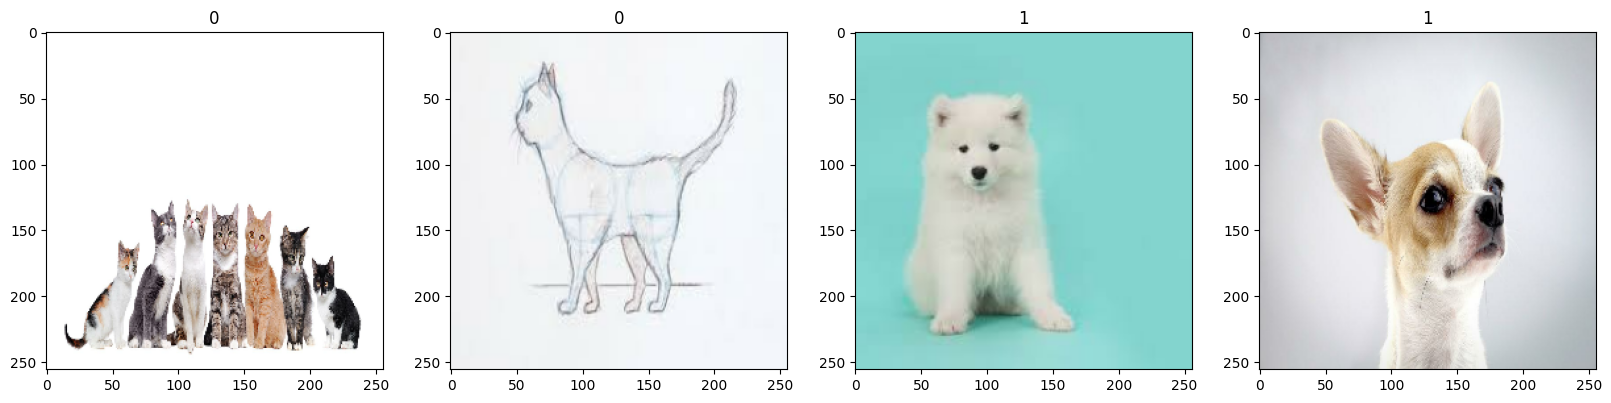

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

--------------
**Scale data**

In [7]:
data = data.map(lambda x,y: (x/255, y))

--------------
**Split data**

In [8]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [9]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

--------------
**Build model**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [11]:
model = Sequential()

In [12]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

--------------
**Training**

In [15]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20


15/15 [==============================] - 4s 197ms/step - loss: 0.7352 - accuracy: 0.5167 - val_loss: 0.6825 - val_accuracy: 0.6953
Epoch 2/20
15/15 [==============================] - 3s 193ms/step - loss: 0.6857 - accuracy: 0.5771 - val_loss: 0.6615 - val_accuracy: 0.6484
Epoch 3/20
15/15 [==============================] - 3s 192ms/step - loss: 0.6495 - accuracy: 0.6271 - val_loss: 0.6257 - val_accuracy: 0.6953
Epoch 4/20
15/15 [==============================] - 3s 191ms/step - loss: 0.5886 - accuracy: 0.7146 - val_loss: 0.4923 - val_accuracy: 0.7656
Epoch 5/20
15/15 [==============================] - 3s 191ms/step - loss: 0.5196 - accuracy: 0.7437 - val_loss: 0.4937 - val_accuracy: 0.7578
Epoch 6/20
15/15 [==============================] - 3s 194ms/step - loss: 0.4049 - accuracy: 0.8188 - val_loss: 0.4951 - val_accuracy: 0.7344
Epoch 7/20
15/15 [==============================] - 3s 192ms/step - loss: 0.3835 - accuracy: 0.8375 - val_loss: 0.3634 - val_accuracy: 0.8828
Epoc

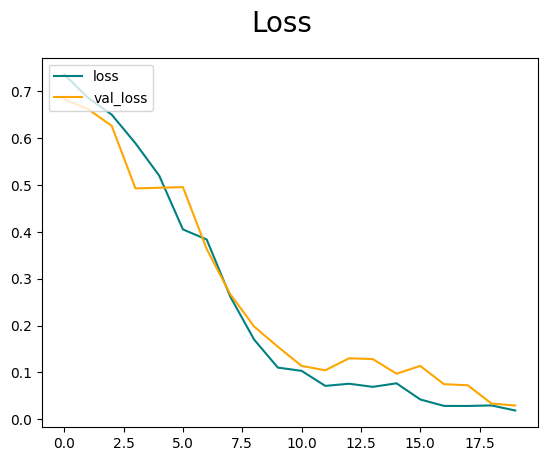

In [16]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

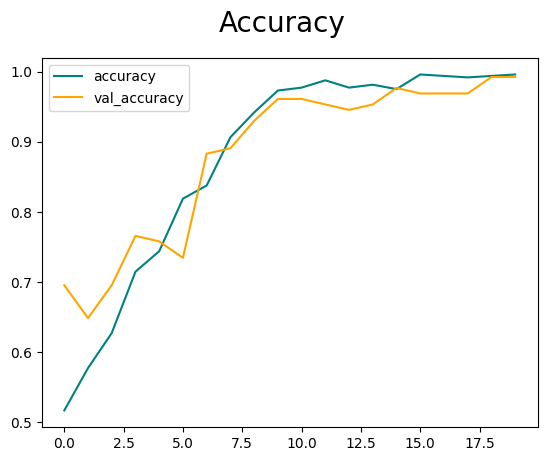

In [17]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

--------------
**Evaluation**

In [18]:
import cv2
import onnxruntime as rt

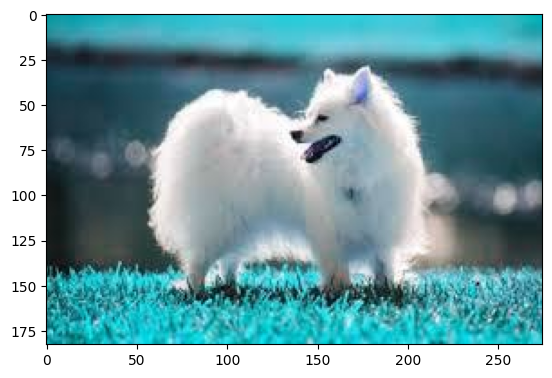

In [19]:
img = cv2.imread('dataset/dogs/dog_109.jpg')
plt.imshow(img)
plt.show()

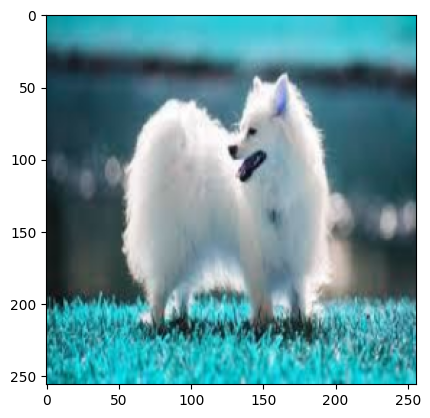

In [20]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [21]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 67ms/step


In [22]:
yhat

array([[0.9999841]], dtype=float32)

In [23]:
if yhat > 0.5: 
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

Predicted class is Dog


--------------
**Save model**

In [24]:
from tensorflow.keras.models import load_model
import tf2onnx
import onnx
import os

In [25]:
model_proto, _ = tf2onnx.convert.from_keras(model)
os.makedirs("models", exist_ok=True)
onnx.save(model_proto, "models/model.onnx")

--------------
**Test onnx model**

In [26]:
import onnxruntime as rt

In [27]:
sess = rt.InferenceSession("models/model.onnx", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

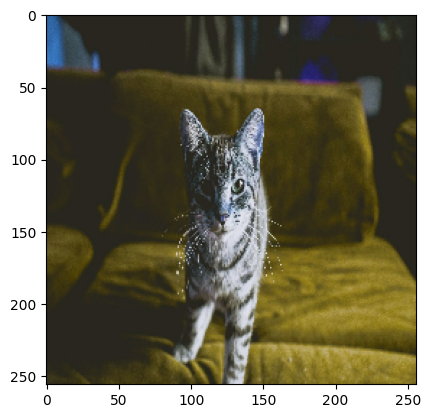

In [28]:
img = cv2.imread('dataset/cats/cat_3.jpg')
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [29]:
y_pred = sess.run([output_name], {input_name: np.expand_dims(resize/255, 0)})

In [30]:
if y_pred[0] > 0.5: 
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

Predicted class is Cat
